# Extract 1D Spectra From SOSS Observations

After time-series observations are taken in NIRISS SOSS mode, the data can be cleaned and calibrated using the TSO branch of the JWST pipeline. We will NOT cover that step in this notebook but will instead begin with some data that mimicks the "Level 3" calibrated output of the JWST pipeline. 

Let's begin with some imports...

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from astropy.io import fits
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import numpy as np
import warnings
import glob

warnings.simplefilter("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Take a look at the observations

The primary starting point for all Level 3 processing of time-series data (spectra and photometry) are datacubes that contain the 2D "slope" images, which have had basic corrections/calibrations applied (bias, dark, flat, etc.). The fits file here contains primary header information, the 2D images, and a table of julien dates (JD) that correspond to the center of each integration (time standards beyond JD such as BJD_UTC, BJD_TT, and HJD will be provided).

In [5]:
# Let's look at the FITS header (though there is no 2D data in this demonstration file!)
filename = 'data/niriss_soss_WASP107_empty.fits'
fits.getheader(filename)

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
DATE    = '2017-03-03T11:30:25.982' / Date this file was created (UTC)          
ORIGIN  = 'STScI   '           / Organization responsible for creating file     
TIMESYS = 'UTC     '           / principal time system for time-related keywords
FILENAME= 'niriss_uncal_soss_gj436_exposure_dq_init_saturation_ipc_superbias_l&'
CONTINUE  'inearity_dark_current_rateints.fits&'                                
CONTINUE  '' / Name of the file                                                 
FILETYPE= 'uncalibrated'       / Type of data in the file                       
SDP_VER = '2016_1  '           / Data processing software version number        
PRD_VER = 'PRDDEVSOC-D-012'    / S&OC PRD version number used in data processing
CAL_VER = '0.7.7   '        

In [6]:
# Let's grab the 2D data using a workaround for Github's 100MB file size limit!
# Normally, we would just do `data2D = fits.getdata(filename)'
data2D = np.concatenate([np.load(fn) for fn in glob.glob('data/niriss_soss*.npy')])[:,:,::-1]
print(data2D.shape)

(333, 256, 2048)


Notice the shape of the data is `(333, 256, 2048)` since the reduced data are comprised of 333 slope images of the SOSS SUBSTRIP256 subarray, which is 256 rows and 2048 columns. Let's take a glance at one of the integrations.

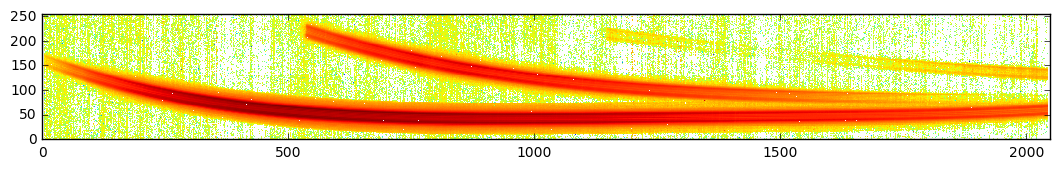

In [7]:
plt.figure(figsize=(13,2))
plt.imshow(data2D[0], interpolation='none', norm=LogNorm(), origin='lower')

The image above should clearly show the three orders of the NIRISS SOSS spectra (1st, 2nd, and 3rd from bottom to top). The 1st order covers roughly 0.7-2.8 microns, the 2nd order covers roughly 0.6-1.3 microns, and the 3rd order covers roughly 0.6-0.85 microns. Wavelength increases to the right in the image above, with the 1st and 2nd order overlapping at the long wavelength end.

Results from the ISIM Cryo-vacuum Test 3 suggest that the actual data that come off the telescope will look slightly different, with somewhat more of a counter-clockwise rotation and somewhat more overlap of the 1st and 2nd order traces past pixel column 1300. The 3rd order trace will likely be unusable in all but the highest signal-to-noise observations.

## Quickly extract the 1D spectra from the 2D trace data

What we would like from these data are an array of 333 1-D spectra for each spectral order along with their associated Julian Days. Then we can fit lightcurves to the spectra to find our planet.

In the interests of time, we will extract only the 1st order spectra. The routine below assigns an average wavelength to each of the 2048 columns of the SOSS subarray, applies a mask to isolate the 1st order trace from background and higher order pixels, and then performs a simple column sum. 

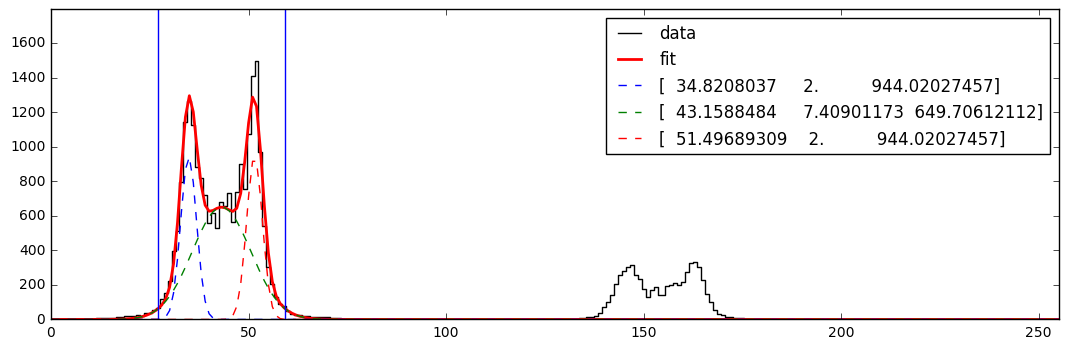

In [8]:
# Look at the cross section
bat_bounds = ([1,2,100,3,50,1],[120,5,1500,10,1500,20])
psf = spec1D.isolate_signal(data2D[23][:,800], func=spec1D.batman, bounds=bat_bounds, plot=True)

If we look at column 700, we can see the PSF for the 1st and 2nd order traces are a bounded triple gaussian, which looks like Batman. To create an aperture mask, we can just take the median frame and fit a Batman function column-by-column to isolate the trace pixels.

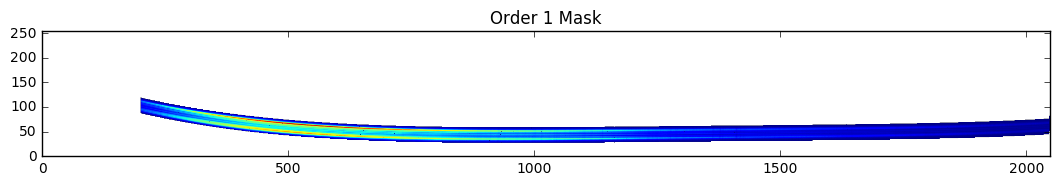

In [9]:
# This code takes about 5 minutes to run so we will just load the precomputed mask
"""
import get1Dspectrum as spec1D

# Get the median frame to mask
med_data2D = np.nanmedian(data2D, axis=0)

# Isolate the 1st order trace by fitting a function to each column (~5 minutes)
mask = spec1D.function_trace(med_data2D.T, func=spec1D.batman, bounds=bat_bounds, smooth='', start=(200,100), plot=True).mask
"""

# Load the mask
mask = np.load('data/sim_mask_fit.npy')
mask[:,:200] = True

# Make it the correct shape
full_mask = np.dstack([mask]*len(data2D)).T.swapaxes(1,2)

# Mask the 2D data
masked_data2D = np.ma.array(data2D.copy(), mask=full_mask)
plt.figure(figsize=(13,2))
plt.imshow(masked_data2D[0], origin='lower')
plt.title('Order 1 Mask')

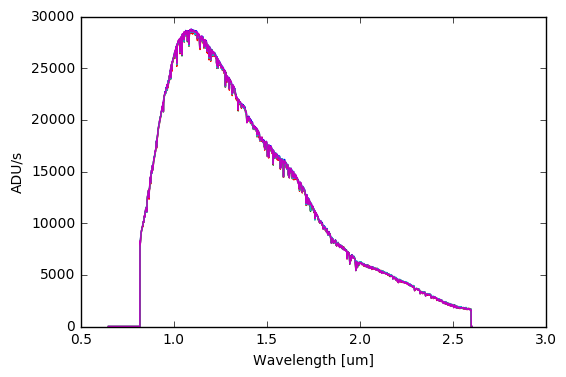

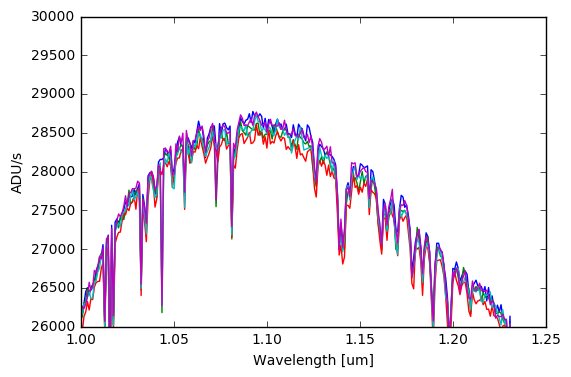

In [13]:
# Sum the counts in each column
counts = np.nansum(masked_data2D, axis=1).data

# Generate a wavelength for each column
wavelength = np.polyval([1.66371e-14,-4.19166e-11,3.09333e-08,-0.000984839,2.60188], np.arange(2048))[::-1]

# Take a look!
plt.figure()
for c in counts[::75]:
    plt.plot(wavelength, c)
plt.xlabel('Wavelength [um]')
plt.ylabel('ADU/s')

# Zoom in
plt.figure()
for c in counts[::75]:
    plt.plot(wavelength, c)
plt.xlabel('Wavelength [um]')
plt.ylabel('ADU/s')
plt.xlim(1,1.25)
plt.ylim(26000,30000)

# Export the results
np.savez('data/extracted_1D_spectra.npz', x=wavelength, y=counts)

## Optimally extract the 1D spectra from the 2D trace data

We could also optimally extract the time-series 1D data, but that clocks in at a significantly longer runtime of about 30 minutes so we will not cover it in this workshop. The optimal extraction routine performs a true background subtraction, takes into account the trace curvature, corrects for order 1 and 2 overlap, and provides uncertainties.

Here's a look at some Cryo-vacuum Test 3 data which shows the more realistic trace shape with 1st and 2nd orders extracted.

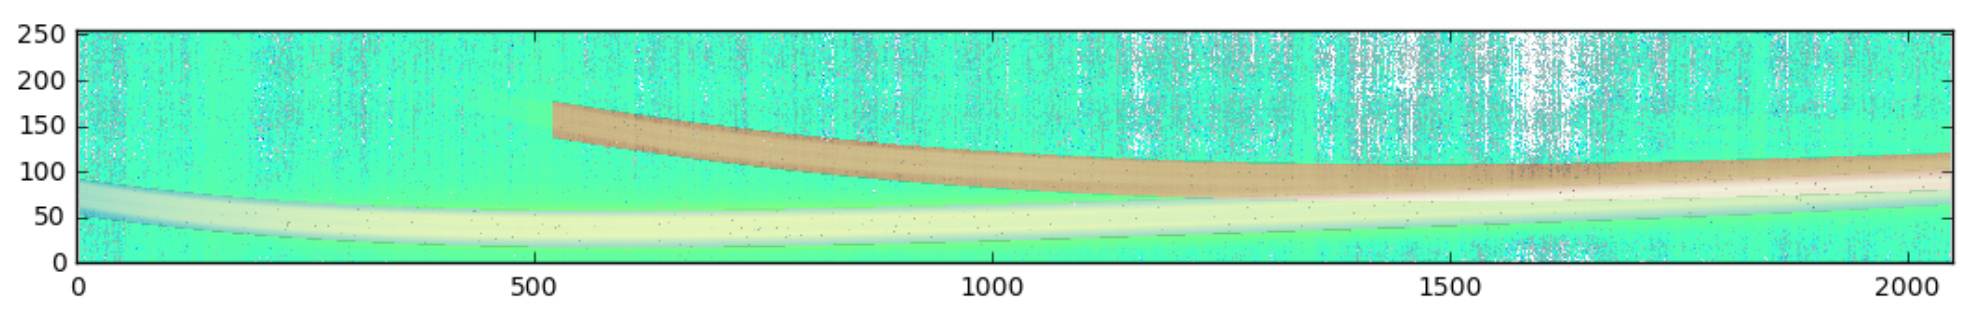

In [19]:
from IPython.display import Image
Image("cv3_data.png")

### This notebook was put together using code and results from Joe Filippazzo, Nikole Lewis, Jason Rowe, and Kevin Volk.